* Problem: Predict whether a customer will default on a loan based on their financial and demographic info. 
* ML Framework: scikit-learn
* Link to dataset: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset?resource=download 

In [24]:
#=========IMPORT LIBRARIES=========
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pathlib import Path
#for histograms
import matplotlib.pyplot as plt
#for boxplots
import seaborn as sns

In [25]:
#=========LOAD DATA=========
#Project root (one level up from notebooks/)
project_root = Path().resolve().parent

#Example: local CSV
data = pd.read_csv(project_root / "data" / "UCI_Credit_card.csv")
#not needed to train and test with
data.drop(columns=['ID'])

#Quick Look
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


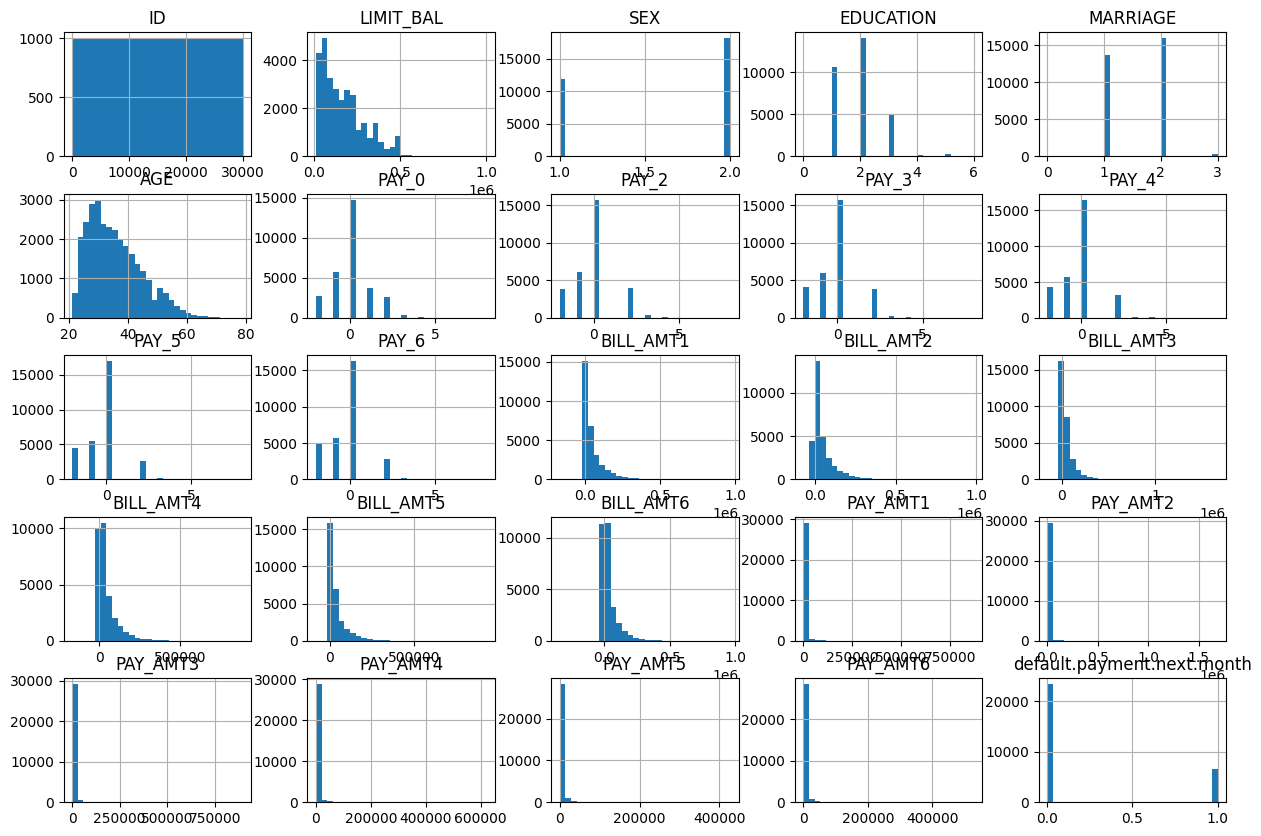

In [26]:
#histogram
#bins determines how many bars the histogram has
#figsize controls the size of the entire figure (width x height in inches)
data.hist(bins=30, figsize=(15,10))
plt.tight_layout
plt.show()

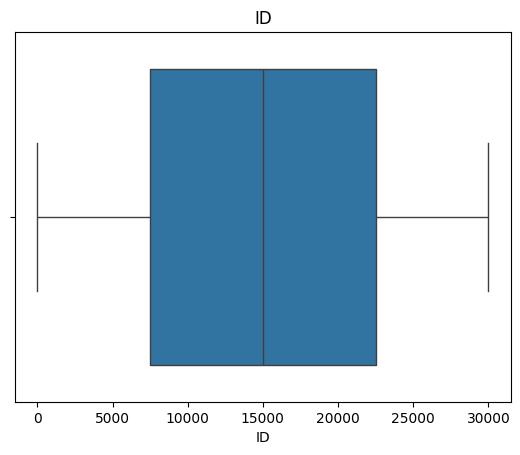

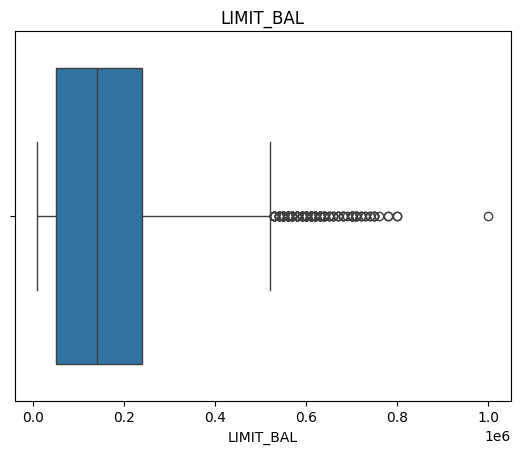

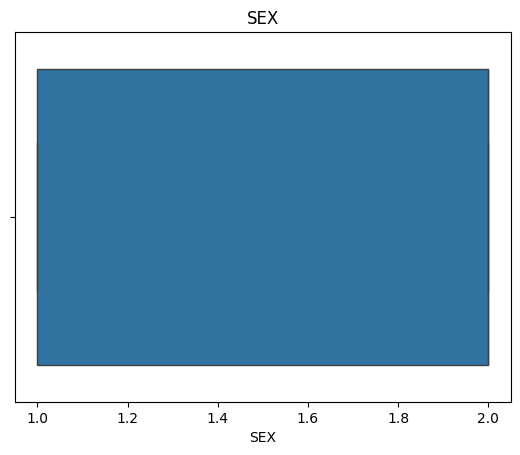

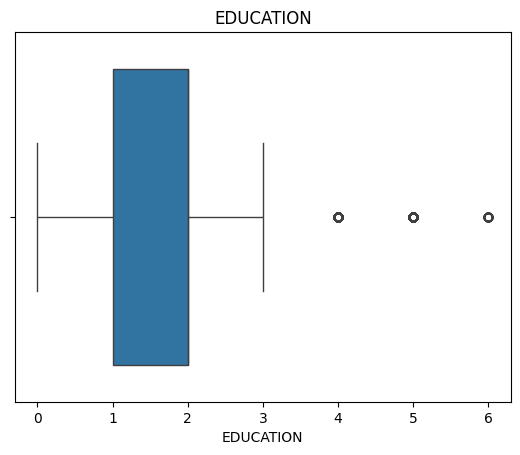

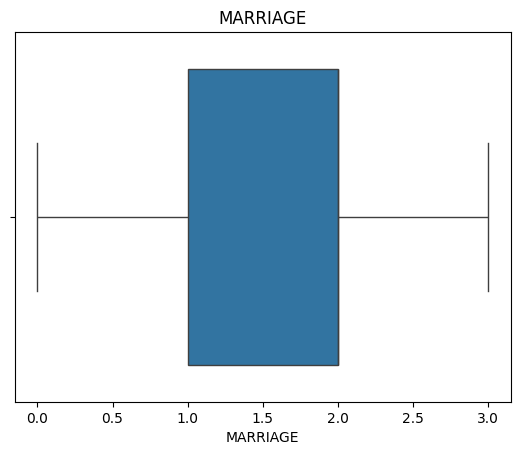

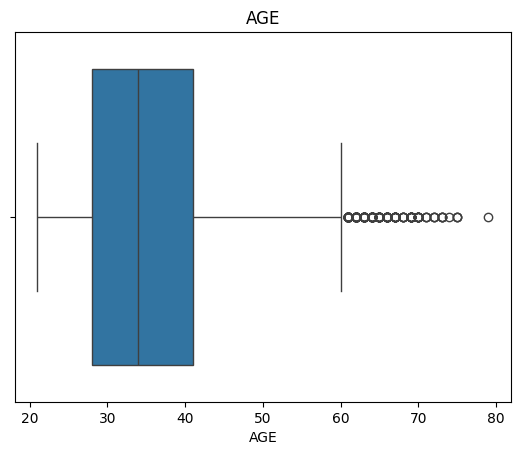

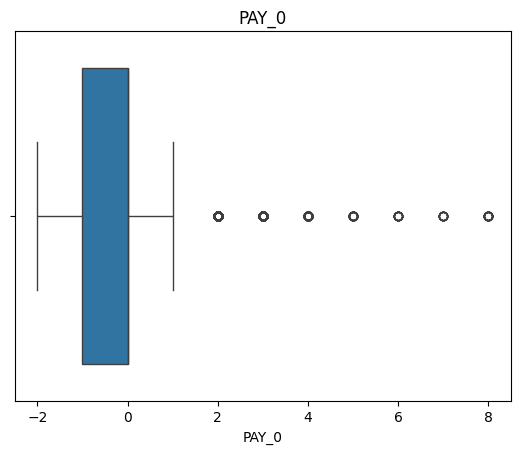

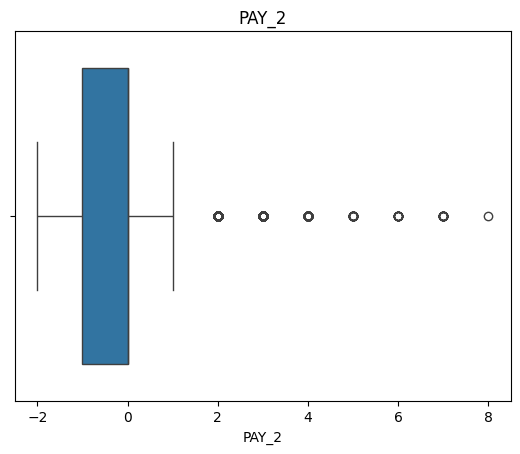

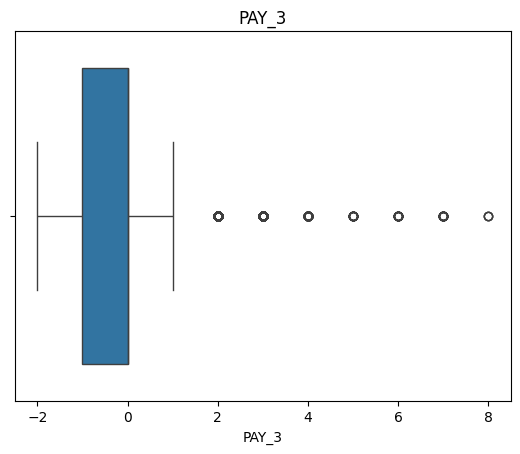

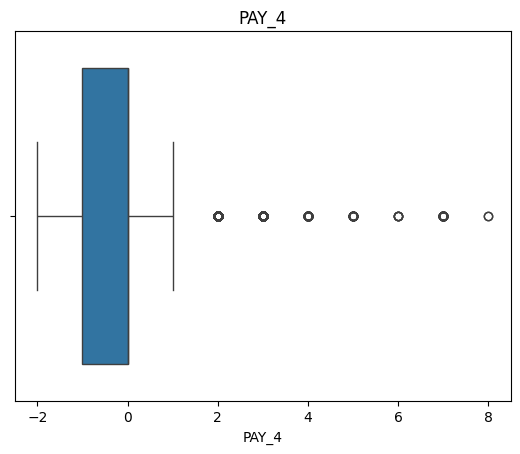

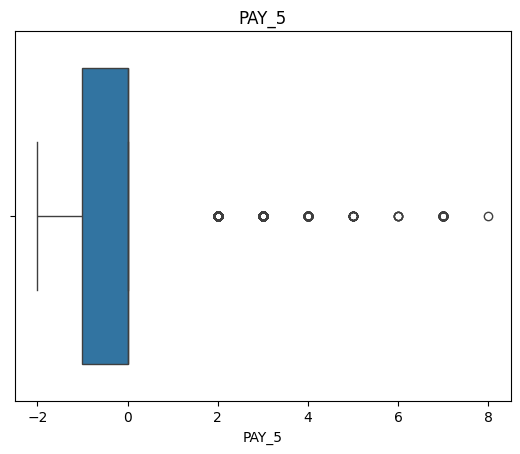

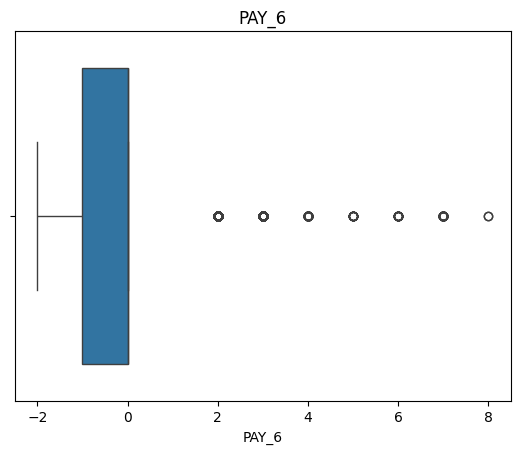

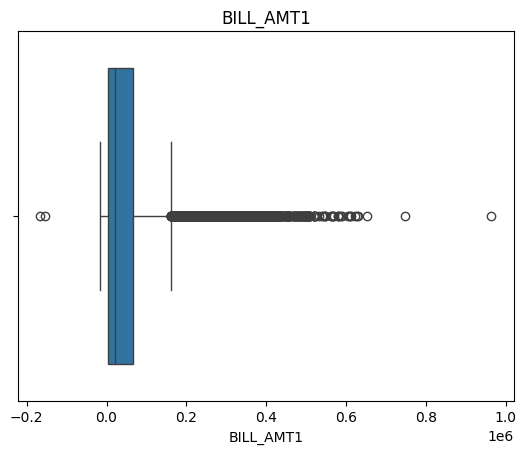

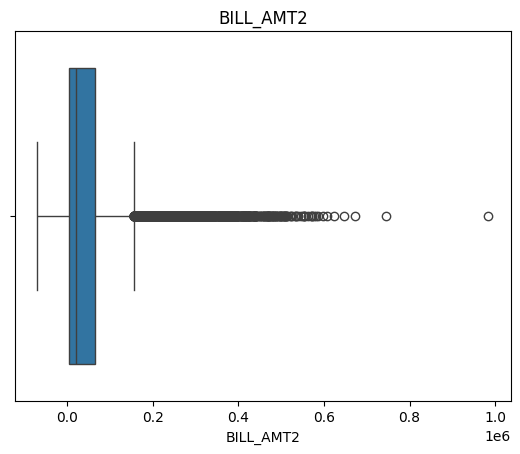

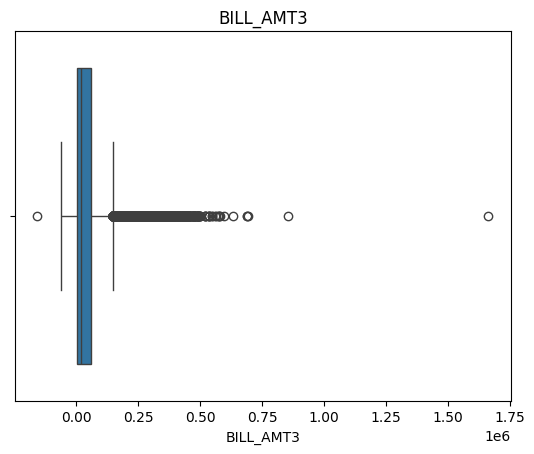

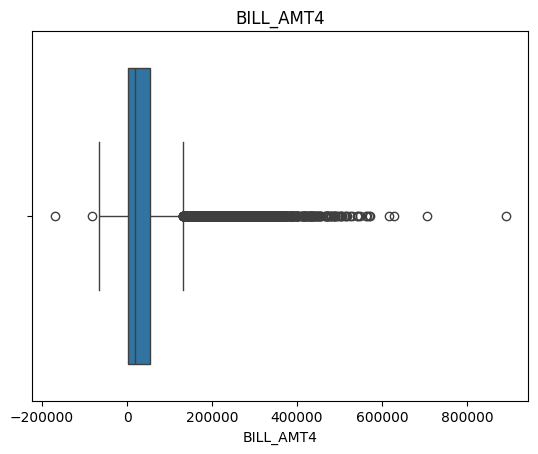

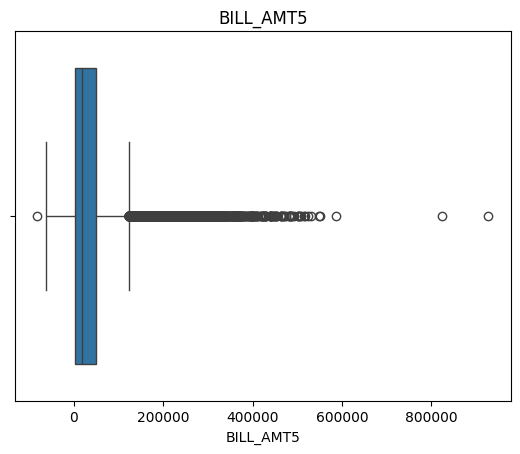

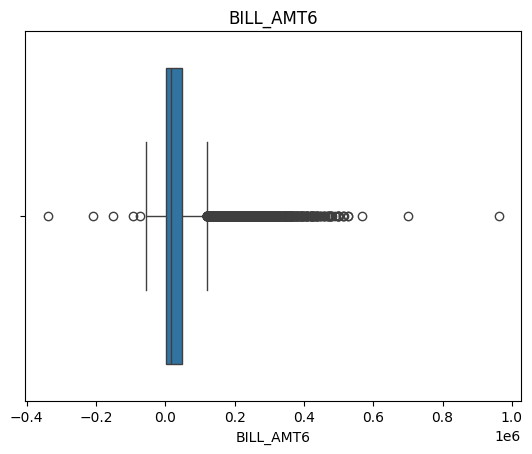

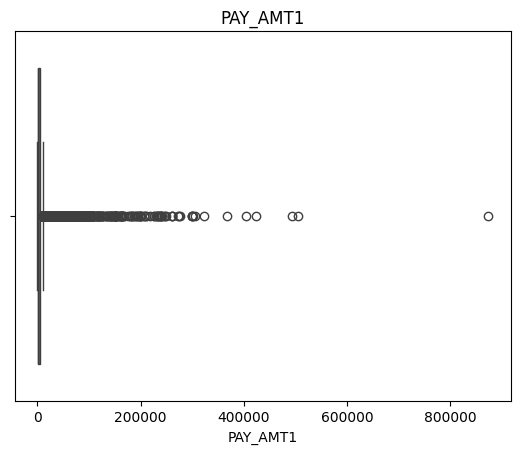

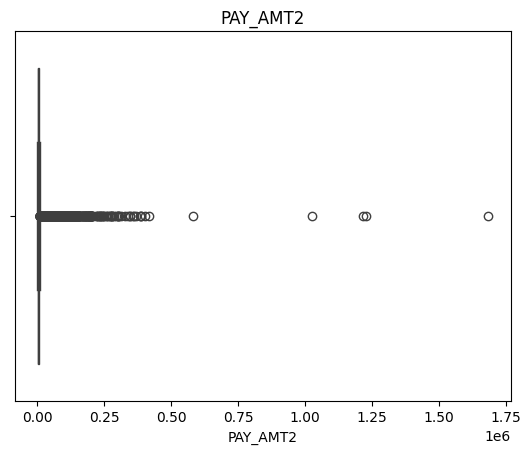

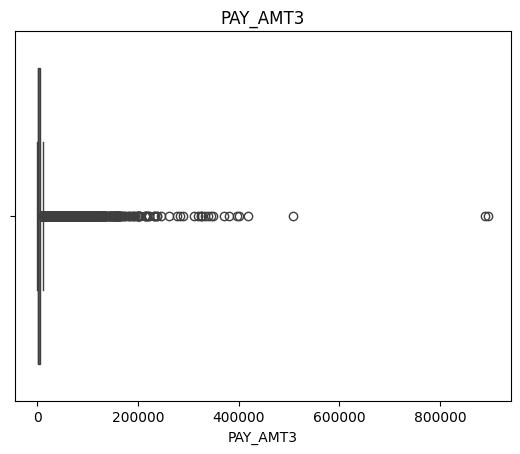

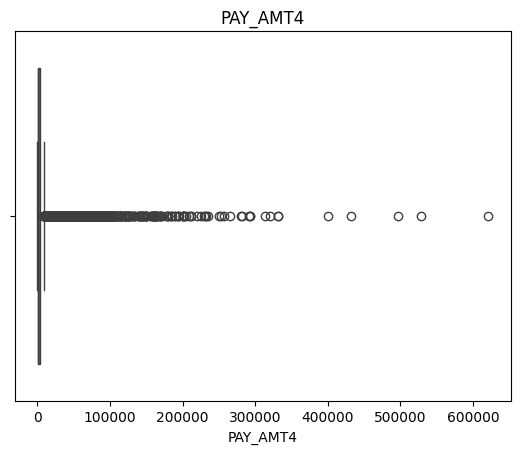

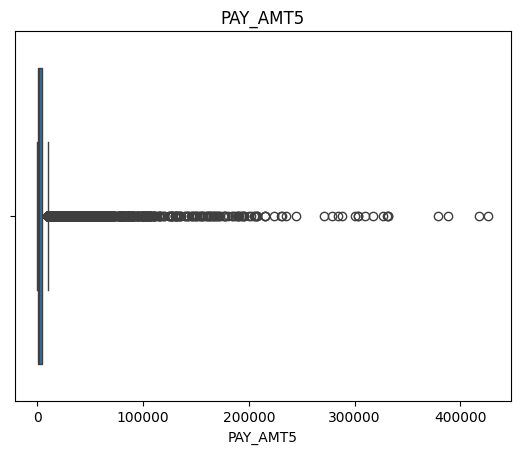

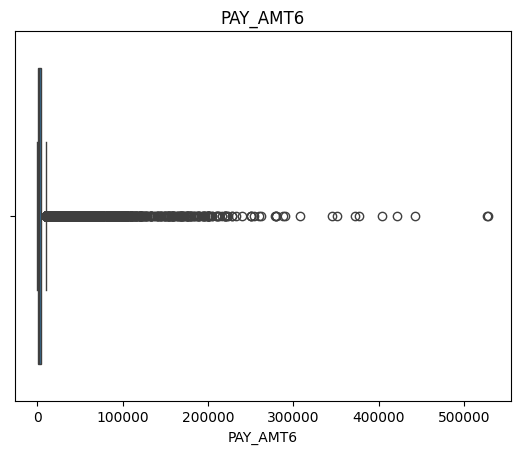

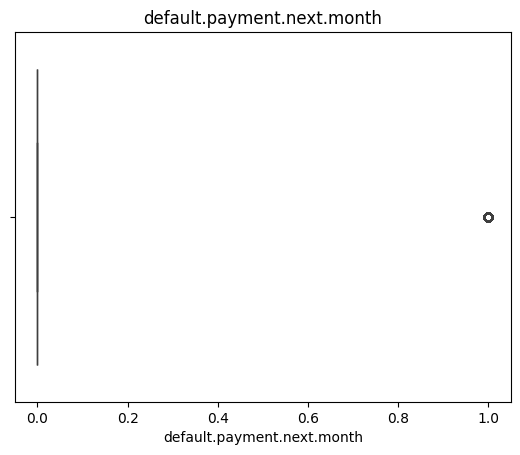

In [27]:
#boxplot
#boxplots show median, quartiles, and outliers
numeric_cols = data.select_dtypes(include='number').columns

for col in numeric_cols:
    sns.boxplot(x=data[col])
    plt.title(col)
    plt.show()

In [28]:
#=========PREPROCESSING=========
# Handle missing values        
# Encode Categorical features  
# Scale numerical features     

#Example of preprocessing pipeline
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
numeric_features = [col for col in data.columns if col not in categorical_features + ['default.payment.next.month']]

# preprocessor - a preprocessor is basically a *set of instructions that tells the model how to handle 
# raw data before training*. Real-world data is not usually ready to go straight into machine learning model. 
# It is the data cleaner + translator that makes messy raw data usable for ML.
# for ex: 
#   * some numbers might be on different scales (think like income in thousands, but then age in years, credit score in 3 dig.)
#   * some features are categorical like martial status which a model cant read as text
#   * some columns might have missing values
# 
# to solve this the preprocessor
#   * scales numeric features -> so features are comparable in test_size
#   * encodes categorical features -> turning words into numbers
#   * handle missing data, feature selection, etc.


# StandardScaler is applied to numeric columns which basically means making them 0, std 1.
# OneHotEncoder is applied to categorical columns which converts text to binary columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [29]:
#=========SPLIT DATA=========

#This part does literally what it says:
#Drop 'Defaulted' from the data set
X = data.drop(columns=['default.payment.next.month'])
#'y' will only extrapolate the target column 'default.payment.next.month'
y = data['default.payment.next.month']

#The train_test_split function splits the dataset into two parts
#    * Training set (what the model learns from)
#    * Test set (unseen data to check if the model generalizes)
#
#Parameters:
#   * X,y -> input features and target
#   * test_size = 0.2 -> 20% of the data goes to test, 80% to train
#   * random_state = 42 -> ensures the split is the same every time (reproducibility)
#
#Result
#   * X_train = training input features
#   * X_test = test input features
#   * y_train = training target values
#   * y_test = test target values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#=========BUILD MODEL=========

#Random Forest Classifier inside a pipeline

#What random_state does:
#   * random_state is a seed for the random number generator used by functions like train_test_split,
#     shuffle, or any algorithim that has a randomness (like RandomForest or KMeans).
#   * Setting it ensures reproducibility: every time the code gets ran with the same random_state,
#     it ensure the same split or results. W/o it, each run could give slightly different outputs. 
#     Using 42 ensures the generator starts at the same point every time. "Randomly picking rows the same way
#     each run."      
#
#RandomForestClassifier is a type of ensemble machine learning module used for classification tasks
#like predicting discrete categories such as yes/no, 0/1, etc.
#"forest" meaning lots of decision trees.
#
clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
#=========EVALUATE MODEL=========

#predict() basically 
#   * takes each test row
#   * applies the learned weight and rules from earlier
#   * produces a probability
#   * converts probability -> 0 or 1 (threshold = 0.5 by default)
y_pred = clf.predict(X_test)

In [32]:
#Print the metrics in percent form function
def print_metrics_percent(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")


print_metrics_percent(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 81.67%
Precision: 64.57%
Recall: 35.95%
F1 Score: 46.18%
Confusion Matrix:
 [[4428  259]
 [ 841  472]]


In [33]:
#=========SAVE MODEL=========

import joblib
joblib.dump(clf, project_root / 'models' / 'credit_default_model.pkl')

['C:\\Users\\shteh\\Documents\\Get  A Job\\Frost Bank\\credit_default_prediction\\models\\credit_default_model.pkl']